# Phase cube

A phase cube is computed from a scan of a flat source. 
It is used to:
* obtain an order 0 phase map when the target is too bright to compute a reliable internal phase
* obtain a high order phase

job file:
```
WAVENUMBER 1
WAVE_CALIB 1
APOD 1.0
CALIBMAP LASER_None.cam1.calibration_laser_map.fit.fits
OBS data/ar42/19aq65/2392276c.fits
OBS data/ar42/19aq65/2392277c.fits
OBS data/ar42/19aq65/2392278c.fits
OBS data/ar42/19aq65/2392279c.fits
OBS data/ar42/19aq65/2392280c.fits
OBS data/ar42/19aq65/2392281c.fits
OBS data/ar42/19aq65/2392282c.fits
OBS data/ar42/19aq65/2392283c.fits
OBS data/ar42/19aq65/2392284c.fits
OBS data/ar42/19aq65/2392285c.fits
OBS data/ar42/19aq65/2392335c.fits
OBS data/ar42/19aq65/2392336c.fits
OBS data/ar42/19aq65/2392337c.fits
OBS data/ar42/19aq65/2392338c.fits
OBS data/ar42/19aq65/2392339c.fits
```

command:
```bash
orbs sitelle phase.job start --flat
```


In [28]:
import orbs.phase
import orb.fft
import pylab as pl
phase = orb.fft.Phase('/reductions2/sitelle/phase/flats_SN2/CAM1/flats_SN2.cam1.Interferogram.high_order_phase.hdf5')
phase_std = orb.fft.Phase('/reductions2/sitelle/phase/flats_SN2/CAM1/flats_SN2.cam1.Interferogram.high_order_phase_std.hdf5')
phase = phase.cleaned()
phase_std = phase_std.cleaned()
print(phase.dimx)

2001


In [30]:
model = orb.utils.io.read_fits('/reductions2/sitelle/phase/SN2/flats_SN2/CAM1/flats_SN2.cam1.Interferogram.phase_cube_model.fits')

(341, 344, 2001)

In [43]:
pcube = orbs.phase.BinnedPhaseCube('/reductions2/sitelle/phase/SN2/flats_SN2/CAM1/flats_SN2.cam1.Interferogram.binned_phase_cube.hdf5')
pcube.params['calibration_laser_map_path'] = '/reductions2/sitelle/phase/SN2/LASER_None.cam1.calibration_laser_map.fit.fits'

In [50]:
hop = orb.fft.Phase(orb.core.Tools()._get_phase_file_path('SN2'))

(636, 1517)

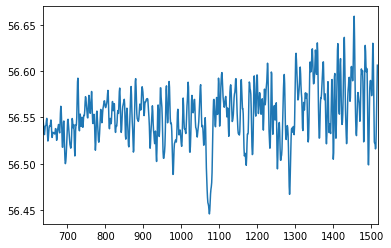

In [51]:
phase = pcube.get_phase(150,150).cleaned()
pl.plot(phase.data - model[150,150,:] - hop.project(phase.axis).data)
pl.xlim(phase.get_filter_bandpass_pix())


In [27]:
p = orb.fft.Phase(orb.core.Tools()._get_phase_file_path('SN2'))
with orb.utils.io.open_hdf5(orb.core.Tools()._get_phase_file_path('SN2'), 'r') as f:
    for i in f.attrs:
        print(i)

date
filter_cm1_max
filter_cm1_min
filter_file_path
order
program
step
zpd_index


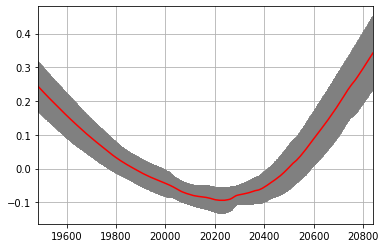

In [24]:
pl.errorbar(phase.axis.data, phase.data, yerr=phase_std.data, ls='none', c='gray')
phase.plot(c='red')
pl.xlim(phase.get_filter_bandpass_cm1())
pl.grid()

(0, 0.1)

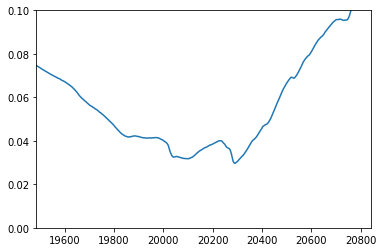

In [10]:
phase_std.plot()
pl.xlim(phase.get_filter_bandpass_cm1())
pl.ylim((0,0.1))

(19485.580670303974, 20842.017507294706)